# Praca domowa 4  - Ada Gąssowska

In [7]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
! pip install category_encoders
import category_encoders
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn import datasets
import warnings 
import seaborn as sns
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import random
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV
random.seed(123)

## Zbiór 1  - apartments 

In [8]:
data1 = pd.read_csv('C:/Users/Ada/Desktop/apartments.csv')

In [9]:
data1.head()

,m2.price,construction.year,surface,floor,no.rooms,district
0,5897,1953,25,3,1,Srodmiescie
1,1818,1992,143,9,5,Bielany
2,3643,1937,56,1,2,Praga
3,3517,1995,93,7,3,Ochota
4,3013,1992,144,6,5,Mokotow


In [10]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
m2.price             1000 non-null int64
construction.year    1000 non-null int64
surface              1000 non-null int64
floor                1000 non-null int64
no.rooms             1000 non-null int64
district             1000 non-null object
dtypes: int64(5), object(1)
memory usage: 47.0+ KB


### Podział na zbiór treningowy i testowy

In [10]:
X1 = data1.drop(['m2.price'], axis=1)
y1 = data1['m2.price']

In [11]:
X_train1,X_test1,y_train1,y_test1=train_test_split(X1,y1,test_size=0.2)

### Kodowanie zmiennej district

In [12]:
te = category_encoders.target_encoder.TargetEncoder(X_train1['district'])

In [13]:
te.fit(X_train1['district'], y_train1)
X_train1.district = te.transform(X_train1['district'])
X_test1.district = te.transform(X_test1['district'])

In [14]:
len(np.unique(X_test1.district))==len(np.unique(X_train1.district)) #każda kategoria jest w zbiorze testowym

True

### Średnia wartość kolumny odpowiedzi 

In [68]:
np.mean(y1)

3487.019

## Dopasowanie modelu SVR 

In [15]:
model1 = SVR()
model1.fit(X_train1,y_train1)
model1.score(X_test1, y_test1)

0.026363049099514924

In [16]:
predictions1 = model1.predict(X_test1)
rmse1 = mean_squared_error(y_test1, predictions1, squared=False)
print("RMSE dla pierwszego zbioru", rmse1)

RMSE dla pierwszego zbioru 938.7419170447455


Wyniki wydają się być bardzo słabe, możliwe jednak ,że na tym zbiorze nie da się ich poprawić. Zobaczymy czy uzyskamy chociaż trochę lepsze poprzez skalowanie i strojenie hiperparametrów.



## SVR na przeskalowanych danych

In [17]:
scaler = preprocessing.MinMaxScaler()
X_train1_scaled =scaler.fit_transform(X_train1)
X_test1_scaled = scaler.transform(X_test1)

In [18]:
model1=SVR()
model1.fit(X_train1_scaled, y_train1)
print('R^2 dla pierwszego zbioru po przeskalowaniu danych', model1.score(X_test1_scaled, y_test1))


R^2 dla pierwszego zbioru po przeskalowaniu danych 0.07006493983152806


In [19]:
predictions1_scaled = model1.predict(X_test1_scaled)
rmse1_scaled = mean_squared_error(y_test1, predictions1_scaled, squared=False)
print("RMSE dla pierwszego zbioru po skalowaniu", rmse1_scaled)

RMSE dla pierwszego zbioru po skalowaniu 917.4322394720621


Widać, że w artykule słusznie zwrócili uwagę na skalowanie danych - $R^2$ się zwiększył a błąd RMSE - zmniejszył.

## Strojenie hiperparametrów

Pędziemy stroić parametry: kernel, C, gamma i degree.



### Nieprzeskalowane

In [21]:
param_list1= {"kernel":['linear', 'rbf', 'sigmoid', 'poly'],
            "C": stats.uniform(2, 10),
            "gamma": stats.uniform(0.1, 1),
            "degree": np.arange(1, 16)
             }
svr = SVR()
random_search1 = RandomizedSearchCV(estimator=svr,
                              param_distributions=param_list1, 
                              cv=3,
                              n_iter=1,
                              n_jobs=-1,
                              verbose=2)
random_search1.fit(X_train1, y_train1) 
random_search1.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.3s finished


{'C': 7.034196400061756,
 'degree': 15,
 'gamma': 0.2536449946517929,
 'kernel': 'rbf'}

In [25]:
best_model1 = random_search1.best_estimator_
best_model1.fit(X_train1, y_train1)

best_model1_pred = best_model1.predict(X_test1)
rmse1_bestmodel = mean_squared_error(y_test1,best_model1_pred, squared=False)
print("RMSE", rmse1_bestmodel)

RMSE 963.4861552316863


In [26]:
best_model1.score(X_test1, y_test1)

-0.02564149584400321

### Skalowane


In [27]:
svr = SVR()
random_search1_scaled = RandomizedSearchCV(estimator=svr,
                              param_distributions=param_list1,
                              n_iter=3, 
                              cv=3,
                              n_jobs=-1,
                              verbose=2)
random_search1_scaled.fit(X_train1_scaled, y_train1) 
random_search1_scaled.best_params_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   12.1s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   12.6s finished


{'C': 11.172892946928496,
 'degree': 9,
 'gamma': 0.8211053321774627,
 'kernel': 'linear'}

In [28]:
best_model1_scaled = random_search1_scaled.best_estimator_
best_model1_scaled.fit(X_train1_scaled, y_train1)

best_model1_pred_scaled = best_model1_scaled.predict(X_test1_scaled)
rmse1_bestmodel_scaled = mean_squared_error(y_test1,best_model1_pred_scaled, squared=False)
print("RMSE", rmse1_bestmodel_scaled)

RMSE 495.35610971484374


In [29]:
best_model1_scaled.score(X_test1_scaled, y_test1)

0.7288936597483632

Różnica między najlepszym modelem dla danych nieprzeskalowanych a danych przeskalowanych jest ogromna. 

In [30]:
print("Najlepszym modelem dla zbioru 1 okazał się model", best_model1_scaled)

Najlepszym modelem dla zbioru 1 okazał się model SVR(C=11.172892946928496, cache_size=200, coef0=0.0, degree=9, epsilon=0.1,
    gamma=0.8211053321774627, kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)


## Zbiór 2 - autoPrice

In [31]:
data2 = pd.read_csv("C:/Users/Ada/Downloads/dataset_2193_autoPrice.csv").drop(['symboling'], axis=1)

In [32]:
data2 = data2.rename(columns={'class':'price'}) #zmiana nazwy class na price

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019047369948>,
      dtype=object)

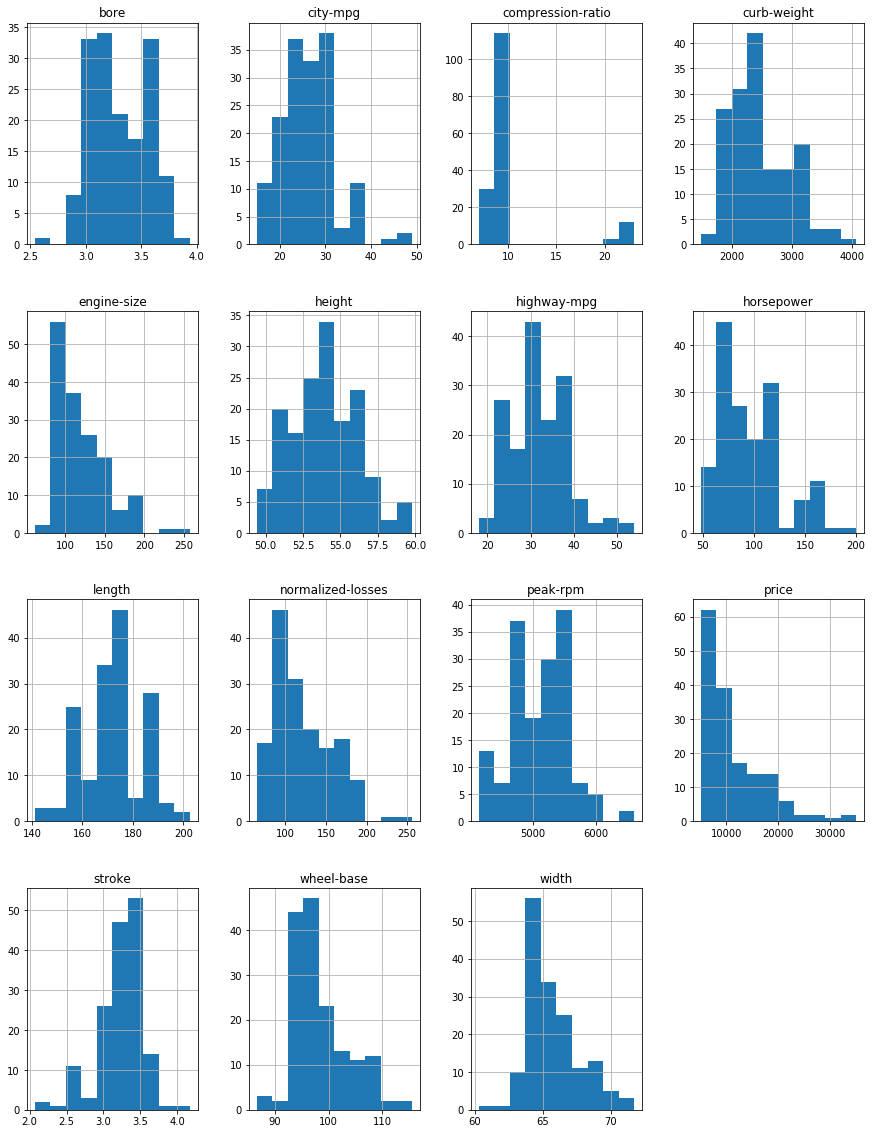

In [33]:
   fig = plt.figure(figsize = (15,20))
   ax = fig.gca()
   data2.hist(ax = ax)

Dane jak widać są numeryczne, nie musimy więc robić encodingu zmiennych kategorycznych

In [34]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 15 columns):
normalized-losses    159 non-null int64
wheel-base           159 non-null float64
length               159 non-null float64
width                159 non-null float64
height               159 non-null float64
curb-weight          159 non-null int64
engine-size          159 non-null int64
bore                 159 non-null float64
stroke               159 non-null float64
compression-ratio    159 non-null float64
horsepower           159 non-null int64
peak-rpm             159 non-null int64
city-mpg             159 non-null int64
highway-mpg          159 non-null int64
price                159 non-null int64
dtypes: float64(7), int64(8)
memory usage: 18.8 KB


In [35]:
data2.describe()

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,121.132075,98.264151,172.413836,65.607547,53.899371,2461.138365,119.226415,3.300126,3.236352,10.161132,95.836478,5113.836478,26.522013,32.081761,11445.729560
std,35.651285,5.167416,11.523177,1.947883,2.268761,481.941321,30.460791,0.267336,0.294888,3.889475,30.718583,465.754864,6.097142,6.459189,5877.856195
min,65.000000,86.600000,141.100000,60.300000,49.400000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,15.000000,18.000000,5118.000000
25%,94.000000,94.500000,165.650000,64.000000,52.250000,2065.500000,97.000000,3.050000,3.105000,8.700000,69.000000,4800.000000,23.000000,28.000000,7372.000000
50%,113.000000,96.900000,172.400000,65.400000,54.100000,2340.000000,110.000000,3.270000,3.270000,9.000000,88.000000,5200.000000,26.000000,32.000000,9233.000000
75%,148.000000,100.800000,177.800000,66.500000,55.500000,2809.500000,135.000000,3.560000,3.410000,9.400000,114.000000,5500.000000,31.000000,37.000000,14719.500000
max,256.000000,115.600000,202.600000,71.700000,59.800000,4066.000000,258.000000,3.940000,4.170000,23.000000,200.000000,6600.000000,49.000000,54.000000,35056.000000


In [36]:
X2 = data2.drop(['price'], axis=1)
y2 = data2.price

### Podział na zbiór treningowy i testowy

In [69]:
X_train2,X_test2,y_train2,y_test2=train_test_split(X2,y2,test_size=0.2)

### Średnia wartość kolumny odpowiedzi


In [70]:
np.mean(y2) 

11445.729559748428

Większa niż w zbiorze 1 - duża szansa że rmse będzie większe.

## Dopasowanie modelu SVR 

###  Zbiór 2

In [38]:
model2 = SVR()

In [39]:
model2.fit(X_train2, y_train2)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [40]:
model2.score(X_test2, y_test2)

-0.21731458544199886

In [41]:
predictions2=model2.predict(X_test2)

In [43]:
rmse2 = mean_squared_error(y_test2, predictions2, squared=False)
print("RMSE dla drugiego zbioru", rmse2)

RMSE dla drugiego zbioru 5436.257913329091


Wyniki są bardzo słabe (tragiczne?), zobaczymy czy uda nam się je polepszyć 

## Skalowanie danych

In [44]:
X_train2_scaled = scaler.fit_transform(X_train2)
X_test2_scaled = scaler.transform(X_test2)

In [45]:
model2=SVR()
model2.fit(X_train2_scaled, y_train2)
print('R^2 dla drugiego zbioru po przeskalowaniu danych', model2.score(X_test2_scaled, y_test2))

R^2 dla drugiego zbioru po przeskalowaniu danych -0.2121502272536635


In [46]:
predictions2_scaled = model2.predict(X_test2_scaled)
rmse2_scaled = mean_squared_error(y_test2, predictions2_scaled, squared=False)
print("RMSE dla pierwszego zbioru po skalowaniu", rmse2_scaled)

RMSE dla pierwszego zbioru po skalowaniu 5424.7142158409215


Wyniki praktycznie takie same, zobaczymy czy cokolwiek da strojenie parametrów (na poprzednim zbiorze zyskaliśmy bardzo dużo dzięki strojeniu). 

## Optymalizowanie hiperparametrów

### nieprzeskalowane


In [47]:
param_list2= {"kernel":['linear', 'rbf', 'sigmoid', 'poly'],
            "C": stats.uniform(2, 10),
            "gamma": stats.uniform(0.1, 1)}
svr = SVR()
random_search2 = RandomizedSearchCV(estimator=svr,
                              param_distributions=param_list2,
                              n_iter=1, 
                              cv=3,
                              n_jobs=-1,
                              verbose=2)
random_search2.fit(X_train2, y_train2) 
random_search2.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.0s finished


{'C': 5.201296114743215, 'gamma': 0.6493465939229863, 'kernel': 'sigmoid'}

In [48]:
best_model2 = random_search2.best_estimator_
best_model2.fit(X_train2, y_train2)

best_model2_pred = best_model2.predict(X_test2)
rmse2_bestmodel = mean_squared_error(y_test2,best_model2_pred, squared=False)
print("RMSE", rmse2_bestmodel)

RMSE 5437.328319128798


In [49]:
best_model2.score(X_test2, y_test2)

-0.21779401408437415

### skalowane

In [58]:
svr = SVR()
random_search2_scaled = RandomizedSearchCV(estimator=svr,
                              param_distributions=param_list2,
                              n_iter=1, 
                              cv=3,
                              n_jobs=-1,
                              verbose=2)
random_search2_scaled.fit(X_train2_scaled, y_train2) 
random_search2_scaled.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


{'C': 9.582942402450467, 'gamma': 0.6626743678880624, 'kernel': 'poly'}

In [59]:
best_model2_scaled = random_search2_scaled.best_estimator_
best_model2_scaled.fit(X_train2_scaled, y_train2)

best_model2_pred_scaled = best_model2_scaled.predict(X_test2_scaled)
rmse2_bestmodel_scaled = mean_squared_error(y_test2,best_model2_pred_scaled, squared=False)
print("RMSE", rmse2_bestmodel_scaled)

RMSE 3976.1037147623524


In [61]:
best_model2_scaled.score(X_test2_scaled, y_test2)

0.34879439731917605

Jak widać uzyskaliśmy wynik dużo lepszy (wszystkie poprzednie wyniki były ujemne). Pokazuje tak jak dużo możemy osiągnąć skalowaniem i strojeniem parametrów. 

In [71]:
print("Najlepszym modelem dla zbioru 2 okazał się model", best_model2_scaled)

Najlepszym modelem dla zbioru 2 okazał się model SVR(C=9.582942402450467, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.6626743678880624, kernel='poly', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)
